In [1]:
## Packages

In [2]:
import numpy as np
import math
from scipy import misc
import matplotlib.pyplot as plt
import time
from __future__ import print_function
%matplotlib inline

## Getting the image

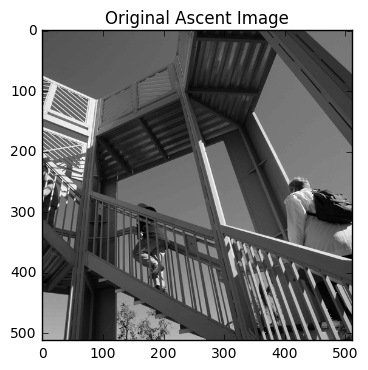

In [3]:
plt.gray()
ascent = misc.ascent()
plt.imshow(ascent)
plt.title("Original Ascent Image")
plt.show()

In [4]:
from numpy.random import random_integers, randint, sample
import random as rnd

## Getting the noisy image

### Test : about how to generate the noisy image

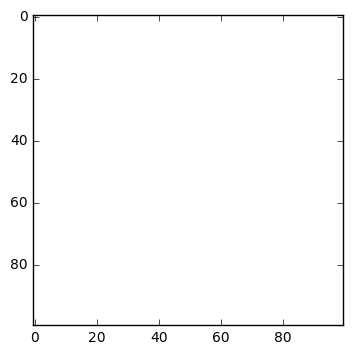

In [5]:
import numpy as np
img = np.zeros((100,100),dtype=np.uint8)
img_size = img.shape[0]*img.shape[1]
img[:] = 255
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
plt.show()

In [6]:
print("Number of pixels in the image: %s" %(img_size))
PropObserved = 0.2
NrandomPoints = int(np.round((1-PropObserved)*img_size, 0))
print("Number of observed points in the noisy image: %.1f%% " %(100*PropObserved))

Number of pixels in the image: 10000
Number of observed points in the noisy image: 20.0% 


#### Method 1

In [7]:
Xs = randint(0, img.shape[0], NrandomPoints)
Ys = randint(0, img.shape[1], NrandomPoints)
# tmp = random_noise(ascent, amount=0.0001)
# plt.imshow(tmp)
# plt.show()

Noisy_img = img.copy()
Noisy_img[Xs, Ys] = 0

1-np.sum(Noisy_img==0)/img_size

1

#### Method 2

In [8]:
import random as rnd

idx = np.array([], dtype=np.int8).reshape(0,2)

for i in range(img.shape[1]):
    a = np.column_stack((np.ones(img.shape[0], dtype=np.int8)*i, np.arange(img.shape[0])))
    idx = np.concatenate((idx, a))
    
np.random.shuffle(idx)

Z = idx[rnd.sample(range(img_size), NrandomPoints),:]
[Xs, Ys] = Z.T

Noisy_img2 = img.copy()
Noisy_img2[Xs, Ys] = 0

1-np.sum(Noisy_img==0)/img_size

1

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


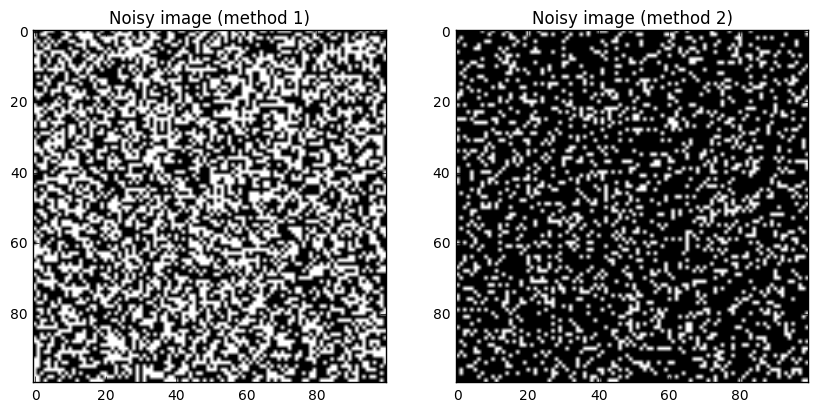

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))

ax1.imshow(Noisy_img)
ax1.set_title("Noisy image (method 1)")

ax2.imshow(Noisy_img2)
ax2.set_title("Noisy image (method 2)")

f.subplots_adjust(hspace=0)
f.show()

In [10]:
import random as rnd

def noise(X, PropObserved):
    '''Returns a noisy version of X given a proportion of observed data'''
    n, m = X.shape
    X_size = n*m
    NrandomPoints = int(np.round((1-PropObserved)*X_size, 0))
    
    idx = np.array([], dtype=np.int8).reshape(0,2)
    for i in range(m):
        a = np.column_stack((np.ones(n, dtype=np.int8)*i, np.arange(n)))
        idx = np.concatenate((idx, a))

    np.random.shuffle(idx)

    Z = idx[rnd.sample(range(X_size), NrandomPoints),:]
    [Xs, Ys] = Z.T
    
    NoisyX = X.copy()
    NoisyX[Xs, Ys] = 0
    
    return(NoisyX)

### Real

In [11]:
print("Number of pixels in the image: %s" %(ascent.size))
PropObserved = 0.2
NrandomPoints = int(np.round((1-PropObserved)*ascent.size, 0))
print("Number of observed points in the noisy image: %.1f%% " %(100*PropObserved))

Number of pixels in the image: 262144
Number of observed points in the noisy image: 20.0% 


In [12]:
Noisyascent = noise(ascent, PropObserved)

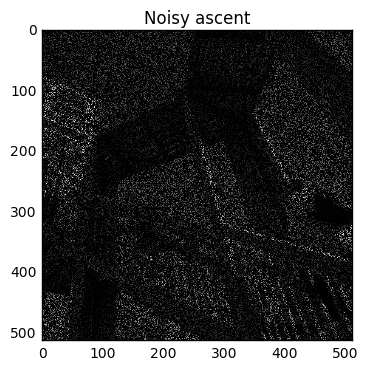

In [13]:
plt.imshow(Noisyascent)
plt.title("Noisy ascent")
plt.show()

## Svd

In [14]:
from numpy.linalg import svd

In [15]:
def project(X, Z=Noisyascent):
    Y = X.copy()
    """
    See slide 11 from http://web.stanford.edu/~hastie/TALKS/SVD_hastie.pdf
    X the predicted image
    Z is the observed image
    """
    Y[Z==0] = 0
    return Y

def project_orth(X, Z=Noisyascent):
    Y = X.copy()
    """
    X the predicted image
    Z is the observed image
    """
    Y[Z>0] = 0
    return Y

In [16]:
#Noisyascent - project(Noisyascent, Noisyascent) # projection works fine

In [17]:
# Il manque pê le term penalisant la somme des val sing de Y

def myLoss(X, Y):
    """
    Loss function to be minimized
    X is the original image corresponding to Noisy Ascent here
    Y is the image predicted
    """
    return np.linalg.norm(project(X) - project(Y))**2

In [18]:
def myMax(X, a):
    """
    Takes the max between 0 and X_i,j - a within X
    """
    X-=a
    X[X < 0] = 0
    return X

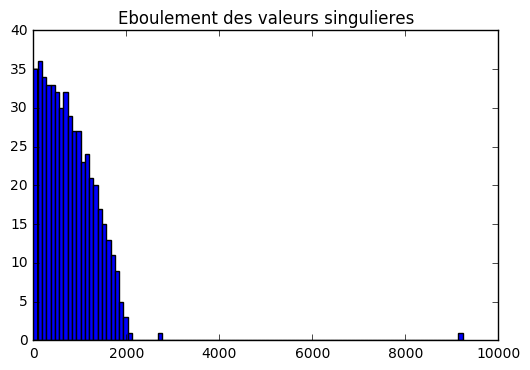

In [19]:
# We first do some sort of warm starting
prediction = Noisyascent + project(np.random.rand(Noisyascent.shape[0], Noisyascent.shape[1]),Noisyascent)

# In this case we will only work with the first singular value
# we know the solution to the minimization problem hence we dont need to use the loss

u, s, v = svd(Noisyascent)

plt.hist(s, bins=100)
plt.title("Eboulement des valeurs singulieres")
plt.show()

### Soft Impute

In [20]:
def soft_threshold_svd(X, lbda):
    u_tmp, s_tmp, v_tmp = svd(X)
    prediction = np.dot(u_tmp, myMax(np.diag(s_tmp), lbda)).dot(v_tmp)
    return(prediction)

def pen_loss(Noisyascent, Z, lbda):
    loss = 1./2*np.linalg.norm(Noisyascent - project(Noisyascent, Z))**2 + lbda*np.linalg.norm(Z, 'nuc')
    return(loss)

In [21]:
def soft_impute(Total_runs=5, Max_iterate=10, epsilon = 0.01, X=Noisyascent, verbose=True, graph=True):

    start_time = time.time()
    
    u, s, v = svd(X)
    
    lbda0 = s[0]
    lbda_seq = np.exp(np.linspace(start=np.log(lbda0), stop=np.log(1.) , num=Total_runs))

    improv_list = []
    distance_list = []

    stackpred = np.zeros((ascent.shape[0], ascent.shape[1],Total_runs))
    Z_old = np.zeros((X.shape[0], X.shape[1]))
    
    if verbose:
        print("i", "iterate", "distance", "improvement", sep='\t')

    for i in range(s.shape[0])[0:Total_runs]: 
        
        #Max_iterate  = max(1000,100-2*i) why?????????

        distance = np.linalg.norm(ascent - Z_old)
        iterate = 0
        improvement = 1000

        while np.logical_and(iterate < Max_iterate, improvement > epsilon): 
        # print(iterate)
            Z_new = soft_threshold_svd(X + project_orth(Z_old), lbda_seq[i])
            ' metrics '
            ' distance to the true image '
            distance = np.linalg.norm(ascent - Z_new)
            ' improvement of Z_new compared to Z_old '
            if np.linalg.norm(Z_old) == 0:
                improvement = 0
            else:
                improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2

            improv_list.append(improvement)
            distance_list.append(distance)
            ' update '
            Z_old = Z_new
            iterate+=1

        stackpred[:,:,i] = Z_new
        
        if verbose:
            print(i, iterate, round(distance,2), round(improvement,4), sep='\t')
            
    end_time = time.time()
    time_delta = end_time - start_time
    
    print("Running time: %.2f seconds" %time_delta)
    
    if graph:
        plt.title("improvement of the penalized loss")
        plt.plot(improv_list, color="orange", linewidth=2)
        plt.show()
        plt.title("evolution of the distance to the true image")
        plt.plot(distance_list, color="orange", linewidth=2)
        plt.show()
    
    return(stackpred)

Running time: 1.54 seconds


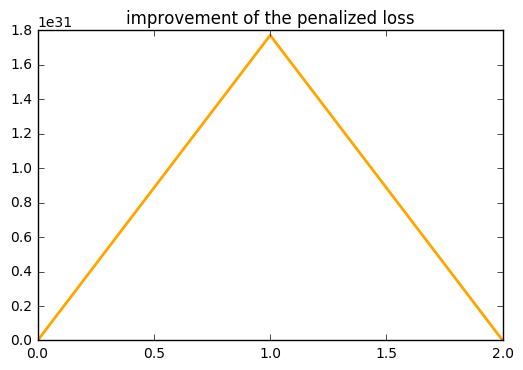

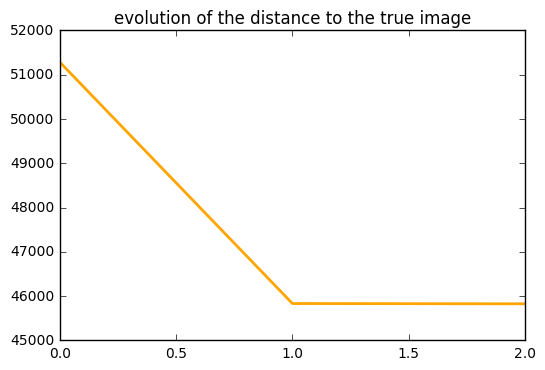

In [22]:
stackpred = soft_impute(Total_runs=2, epsilon=0.00001, verbose=False, graph=True)

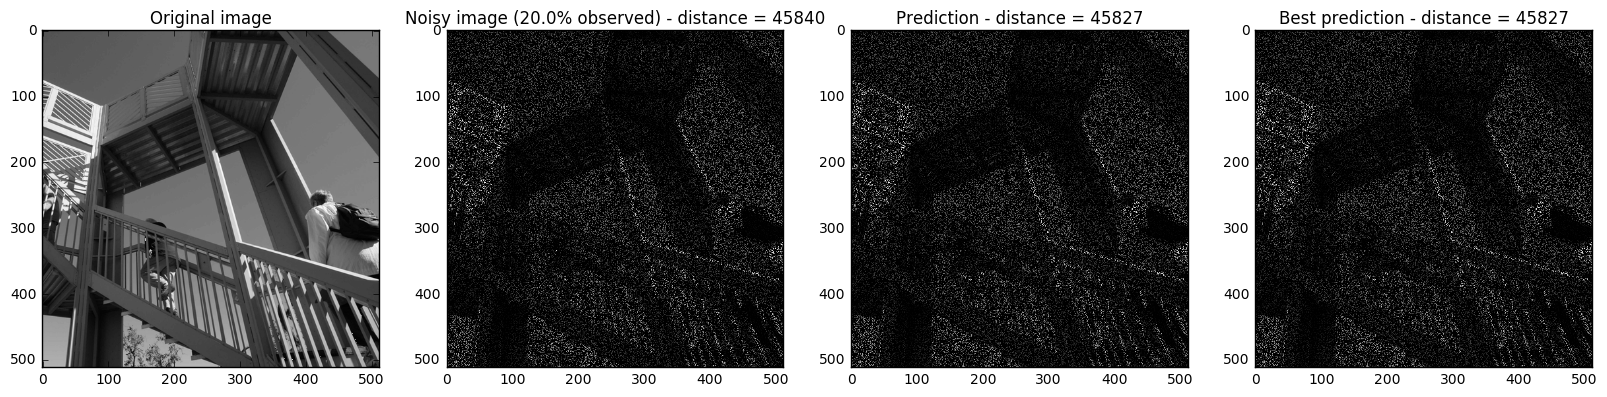

In [23]:
' combination of the input noisy image and optimal completed part '
BestPred = Noisyascent + project_orth(stackpred[:,:,-1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

ax1.imshow(ascent)
ax1.set_title("Original image")

ax2.imshow(Noisyascent)
ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(Noisyascent - ascent)))

ax3.imshow(stackpred[:,:,-1])
ax3.set_title("Prediction - distance = %.f" %(np.linalg.norm(ascent - stackpred[:,:,-1])))

ax4.imshow(BestPred)
ax4.set_title("Best prediction - distance = %.f" %(np.linalg.norm(ascent - BestPred)))

f.subplots_adjust(hspace=0)
f.show()

### Hard Impute

In [24]:
def H(X, r):
    """
    This function performs the rank r truncated SVD approximation of X.
    """
    u, s, v = svd(X)
    u = u[:,:r]
    v = v[:r,:]
    s = s[:r]
    return u, s, v

In [25]:
def hard_impute(Total_runs=5, Max_iterate=20, epsilon=0.01, X=Noisyascent, rank=20, verbose=True, graph=True):
    
    start_time = time.time()
    
    u, s, v = svd(X)

    improv_list = []
    distance_list = []

    stackpred = np.zeros((ascent.shape[0], ascent.shape[1], Total_runs))
    Z_old = np.zeros((X.shape[0], X.shape[1]))

    if verbose:
        print("i", "iterate", "distance", "improvement", sep='\t')
    
    for i in range(s.shape[0])[0:Total_runs]: 
        
        distance = np.linalg.norm(ascent - Z_old)
        iterate = 0
        improvement = 1000

        while np.logical_and(iterate < Max_iterate, improvement > epsilon): 
            # Here we consider the truncated SVD approximation of the input Matrix
            tmp = H(Noisyascent + project_orth(Z_old, X),rank) 
            Z_new = tmp[0].dot(np.diag(tmp[1])).dot(tmp[2])
            ' metrics '
            ' distance to the true image '
            distance = np.linalg.norm(ascent - Z_new)
            ' improvement of Z_new compared to Z_old '
            if np.linalg.norm(Z_old) == 0:
                improvement = 0
            else:
                improvement = (np.linalg.norm(Z_new - Z_old)/np.linalg.norm(Z_old))**2
            
            improv_list.append(improvement)
            distance_list.append(distance)
            ' update '
            Z_old = Z_new
            iterate+=1

        stackpred[:,:,i] = Z_new
        
        if verbose:
            print(i, iterate, round(distance,2), round(improvement,3), sep='\t')
            
    end_time = time.time()
    time_delta = end_time - start_time
    
    print("Running time: %.2f seconds" %time_delta)
   
    if graph:
        plt.title("improvement of the penalized loss")
        plt.plot(improv_list, color="orange", linewidth=2)
        plt.show()
        plt.title("evolution of the distance to the true image")
        plt.plot(distance_list, color="orange", linewidth=2)
        plt.show()
    
    return(stackpred)

Running time: 6.72 seconds


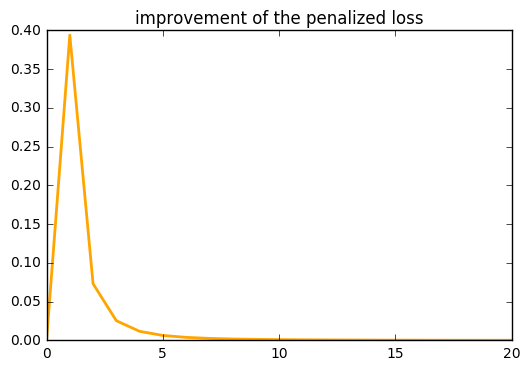

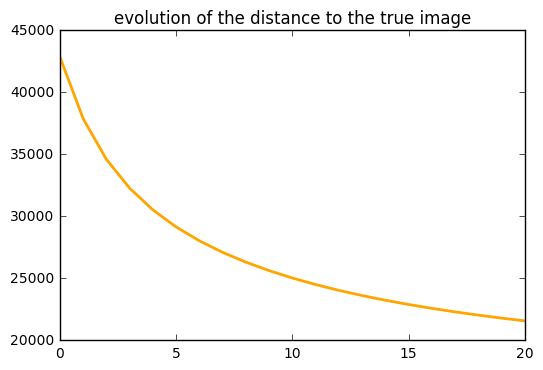

In [26]:
stackpred = hard_impute(Total_runs=2, epsilon=0.00001, verbose=False, graph=True)

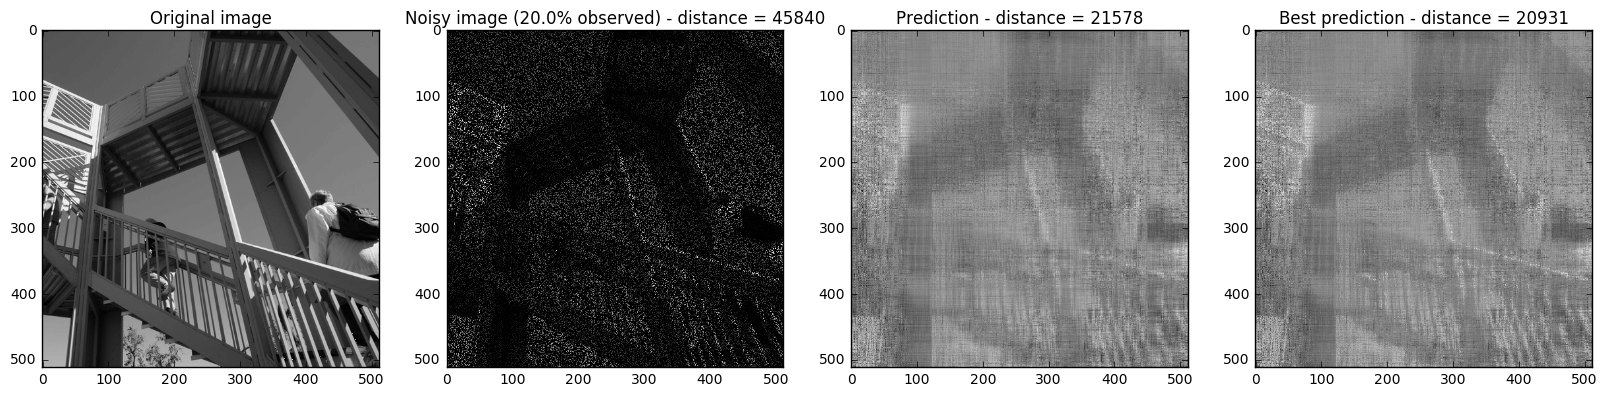

In [27]:
' combination of the input noisy image and optimal completed part '
BestPred = Noisyascent + project_orth(stackpred[:,:,-1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 60))

ax1.imshow(ascent)
ax1.set_title("Original image")

ax2.imshow(Noisyascent)
ax2.set_title("Noisy image (%.1f%% observed) - distance = %.f" %(100*PropObserved, np.linalg.norm(Noisyascent - ascent)))

ax3.imshow(stackpred[:,:,-1])
ax3.set_title("Prediction - distance = %.f" %(np.linalg.norm(ascent - stackpred[:,:,-1])))

ax4.imshow(BestPred)
ax4.set_title("Best prediction - distance = %.f" %(np.linalg.norm(ascent - BestPred)))

f.subplots_adjust(hspace=0)
f.show()

### MMMF

For the computation, one can see that Hastie consider the rank-r approximation (r truncated solution) Z svd and then write Z as the dot product of two matrices A and B

In [28]:
def H(X, r):
    """
    This function performs the rank r truncated SVD approximation of X.
    """
    u, s, v = svd(X)
    u = u[:,:r]
    v = v[:r,:]
    s = s[:r]
    return u, s, v

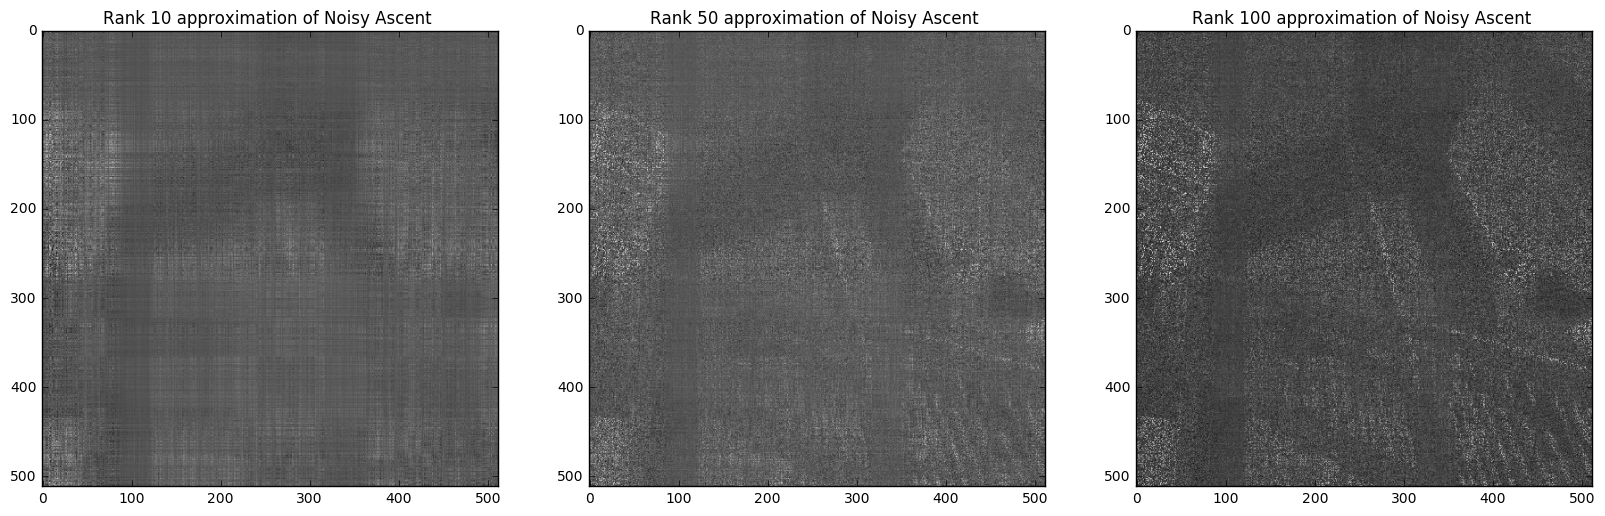

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 60))

u, s, v = H(Noisyascent, 10)

ax1.imshow(np.dot(u, np.diag(s)).dot(v))
ax1.set_title("Rank 10 approximation of Noisy Ascent ")

u, s, v = H(Noisyascent, 50)

ax2.imshow(np.dot(u, np.diag(s)).dot(v))
ax2.set_title("Rank 50 approximation of Noisy Ascent ")

u, s, v = H(Noisyascent, 100)

ax3.imshow(np.dot(u, np.diag(s)).dot(v))
ax3.set_title("Rank 100 approximation of Noisy Ascent ")

plt.show()

In [30]:
# Check https://arxiv.org/pdf/1410.2596.pdf page 8 and 10

def MMMF_tmp(X, r, lbda=1., Max_iter=20):
    #warm start
    u, s, v = H(X,r) #u.shape (512L, 20L) #v.shape (20L, 512L)
    D = np.diag(s) 
    
    A = np.dot(u, D)  #(512L, 20L)
    B = np.dot(v.T,D) #(512L, 20L)
    
    A_new = A
    B_new = B
    
    iter = 0

    while iter <= Max_iter:
        A = A_new #inutile pour la premiere iteration
        B = B_new #inutile pour la premiere iteration
        ReducedNoisyAscent = np.dot(u, np.diag(s)).dot(v)
        X_star = project(ReducedNoisyAscent, X) - project_orth(A.dot(B.T), X) + A.dot(B.T)

        B_tild = np.linalg.solve(D**2 + lbda*np.eye(len(s)), D.dot(u.T).dot(X_star)) # attention transposed

        BD = B_tild.T.dot(D) #(512L, 20L)

        u_tild, s2, v_tild = H(BD, r)   #il n'y a pas d'autre solution que H sinon dim pb
        # u_tild.shape (512L, 20L)
        # v_tild.shape (20L, 20L)
        D = np.diag(np.sqrt(s2))
        B_new = u_tild.dot(D)

        A_tild = X_star.dot(u_tild).dot(D).dot(np.linalg.inv(D**2 + lbda*np.eye(len(s)))) #from page 8
        # A_tild.shape (512L, 20L)
        AD = A_tild.dot(D)
        v_tild, s2, vv_tild = H(AD, r) #u_tild.shape (512L, 20L),v_tild.shape (20L, 20L)

        D = np.diag(np.sqrt(s2))
        A_new = np.dot(v_tild, D) #(512L, 20L)  
        iter+=1

    M = X.dot(v_tild)
    U, d, R = svd(M) #U.shape (512L, 512L) R.shape (20L, 20L)

    A = U.dot(X)
    B = R.T.dot(np.diag(d))
#     plt.imshow(A_new.dot(B_new.T))
    #Normalement A_new*B_new' est une bonne prediction
    output = A_new.dot(B_new.T)
    
    return A_new.dot(B_new.T)

In [31]:
pred = MMMF_tmp(Noisyascent, 2, Max_iter=1)

In [32]:
pred

array([[  4.7847619 ,   5.4096125 ,   4.56662105, ...,   6.58625696,
          8.3025662 ,  11.81671339],
       [  4.50347949,   4.10757127,   5.37105793, ...,   3.02154968,
          4.56934267,   5.7651991 ],
       [  3.84446886,   4.11347382,   3.92329518, ...,   4.53939129,
          5.90239985,   8.22582886],
       ..., 
       [  9.8367905 ,   8.2470077 ,  12.52230368, ...,   4.25871718,
          7.58968563,   8.64588219],
       [  5.54931076,   5.43410291,   6.21206943, ...,   4.92653276,
          6.85937247,   9.13262168],
       [  6.93104593,   6.09128015,   8.51754434, ...,   3.90615844,
          6.2724419 ,   7.6183815 ]])

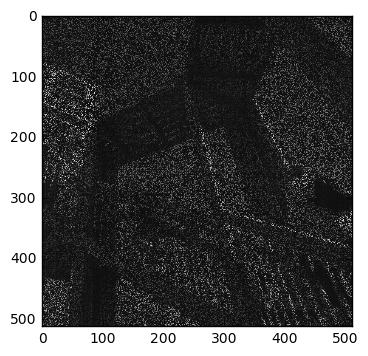

In [33]:
plt.imshow(Noisyascent+project_orth(pred))
plt.show()

In [34]:
def NMF(X, r, lbda=1., Max_iter=200):
    for i in range(Max_iter):
        W = np.random.randint(low=0,high=255,size=(X.shape[0], r))
        H = np.linalg.solve(W.T.dot(W), W.T.dot(X))
        H[H<0] = 0
        W = np.linalg.solve(H.dot(H.T), H.dot(X.T)).T
        W[W<0] = 0
    print(i) 
    print(W.dot(H).shape)
    return W.dot(H)

By running the following code, the problem is to find the rank r to select (r << min(n, m)). There is a trade off between selecting a big r and having low iterations possible before obtaining a singular matrix or selecting a small r and not much improving the Noisy Image.

Since W is set at random, multiples attempt with the same r value may lead to different outcomes.

In [35]:
a= NMF(Noisyascent, 1)

199
(512L, 512L)


In [36]:
a

array([[ 17.91542684,  21.41951978,  24.2434851 , ...,  15.84081019,
         13.38697393,  29.59843539],
       [  9.92978526,  16.56344813,  12.96038697, ...,  12.44465332,
         25.06616685,  25.42773287],
       [ 20.29200833,  13.81932842,  17.35284985, ...,  15.77452929,
         11.81196667,  11.66405709],
       ..., 
       [ 29.76397237,  28.68626228,  28.53106261, ...,  29.2803262 ,
         20.4133901 ,  46.67598751],
       [ 45.60164043,  26.47310928,  27.67422422, ...,  25.767855  ,
         18.17707558,  33.41938286],
       [ 15.04659417,  17.48378984,  33.60110368, ...,  11.00538084,
         19.06618104,  39.54903567]])

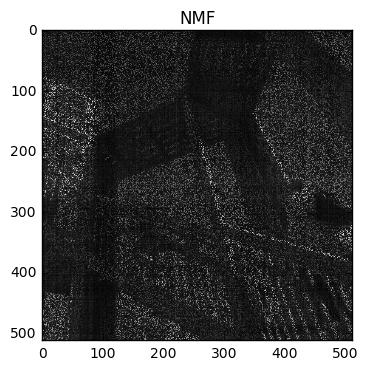

In [37]:
plt.imshow(Noisyascent + project_orth(a))
plt.title("NMF")
plt.show()

In [38]:
b = Noisyascent + project_orth(a)

In [39]:
NMF(b, 10)

199
(512L, 512L)


array([[ 40.35714973,  41.75698457,  54.99827972, ...,  38.93706763,
         39.17578089,  43.43070387],
       [ 25.16883783,  25.1301204 ,  25.45910731, ...,  37.2681874 ,
         32.42289443,  27.95281937],
       [ 34.93850257,  34.62670959,  51.79635412, ...,  39.22517851,
         32.6779448 ,  40.12056204],
       ..., 
       [ 47.15320578,  62.2481787 ,  53.48563824, ...,  41.01114764,
         59.9248597 ,  56.89387544],
       [ 49.13571435,  28.79389858,  37.33241584, ...,  54.54438317,
         52.52538031,  48.2428268 ],
       [ 56.4991228 ,  52.45859246,  50.62649419, ...,  43.00109842,
         58.37179205,  56.82916435]])

199
(512L, 512L)


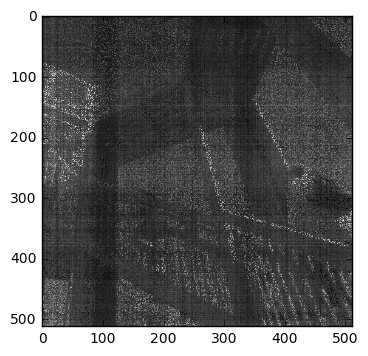

In [40]:
plt.imshow(Noisyascent+project_orth(NMF(b, 50)))

### Robust PCA

In [41]:
# def RobustPCA(X, tol=1e-6, max_iter=10):
#     """ X is a data matrix (of the size N x M) to be decomposed
#     X can also contain NaN's for unobserved values
#     lbd - regularization parameter, default = 1/sqrt(max(N,M))
#     mu - the augmented lagrangian parameter, default = 10*lbd
#     tol - reconstruction error tolerance, default = 1e-6
#     max_iter - maximum number of iterations, default = 1000
#     """
    
#     lbd = 1./np.sqrt(max(X.shape[0], X.shape[1]))
#     mu=10*lbd
#     M, N = np.shape(X)
#     #unobserved = np.isnan(X)
#     #print(unobserved)
#     #X[unobserved] = 0
#     normX = np.linalg.norm(X, 'fro')

#     L = np.zeros((M, N))
#     S = np.zeros((M, N))
#     Y = np.zeros((M, N))
    
#     for iter in range(max_iter):
#         L = Do(1./mu, X - S + (1./mu)*Y)
#         S = So(np.float(lbd/mu), X - L + (1./mu)*Y)
#         Z = X - L - S
#         #Z[unobserved] = 0 # skip missing values
#         Y = Y + mu*Z
        
#         err = np.linalg.norm(Z, 'fro') / normX
# #         if (iter == 1) or ((iter % 10) == 0) or (err < tol):
# #             print(iter, err, np.linalg.matrix_rank(L), nnz(S(~unobserved)))
        
#         if (err < tol):
#             break
#     return Z
        

# def So(tau, X):
#     """shrinkage operator"""
#     r = np.dot(np.sign(X),np.max(np.abs(X) - tau, 0))
#     return r

# def Do(tau, X):
#     """shrinkage operator for singular values"""
#     U, S, V = svd(X)
#     r = U*So(tau, S)*V
#     return r

From https://github.com/dfm/pcp

In [42]:
def robust_pca(M, maxiter=10, verbose = True):
    """ 
    Decompose a matrix into low rank and sparse components.
    Computes the RPCA decomposition using Alternating Lagrangian Multipliers.
    Returns L,S the low rank and sparse components respectively
    """
    L = np.zeros(M.shape)
    S = np.zeros(M.shape)
    Y = np.zeros(M.shape)
    mu = (M.shape[0] * M.shape[1]) / (4.0 * L1Norm(M))
    lamb = max(M.shape) ** -0.5
    iter = 0
    while not converged(M,L,S, verbose) and iter < maxiter:
        if iter % 10 == 0:
            print(iter)
        L = svd_shrink(M - S - (mu**-1) * Y, mu)
        S = shrink(M - L + (mu**-1) * Y, lamb * mu)
        Y = Y + mu * (M - L - S)
        iter+= 1
    return L,S

In [43]:
def svd_shrink(X, tau):
    """
    Apply the shrinkage operator to the singular values obtained from the SVD of X.
    The parameter tau is used as the scaling parameter to the shrink function.
    Returns the matrix obtained by computing U * shrink(s) * V where 
        U are the left singular vectors of X
        V are the right singular vectors of X
        s are the singular values as a diagonal matrix
    """
    U,s,V = np.linalg.svd(X, full_matrices=False)
    return np.dot(U, np.dot(np.diag(shrink(s, tau)), V))

In [44]:
def shrink(X, tau):
    """
    Apply the shrinkage operator the the elements of X.
    Returns V such that V[i,j] = max(abs(X[i,j]) - tau,0).
    """
    V = np.copy(X).reshape(X.size)
    for i in xrange(V.size):
        V[i] = math.copysign(max(abs(V[i]) - tau, 0), V[i])
        if V[i] == -0:
            V[i] = 0
    return V.reshape(X.shape)

In [45]:
def frobeniusNorm(X):
    """
    Evaluate the Frobenius norm of X
    Returns sqrt(sum_i sum_j X[i,j] ^ 2)
    """
    accum = 0
    V = np.reshape(X,X.size)
    for i in xrange(V.size):
        accum += abs(V[i] ** 2)
    return np.sqrt(accum)

def L1Norm(X):
    """
    Evaluate the L1 norm of X
    Returns the max over the sum of each column of X
    """
    return max(np.sum(X,axis=0))

def converged(M,L,S, verbose = True, tol=10e-6):
    """
    A simple test of convergence based on accuracy of matrix reconstruction
    from sparse and low rank parts
    """
    error = frobeniusNorm(M - L - S) / frobeniusNorm(M)
    if verbose:
        print ("error =", error)
    return error <= tol

In [46]:
Z =robust_pca(Noisyascent, verbose=False, maxiter=10)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


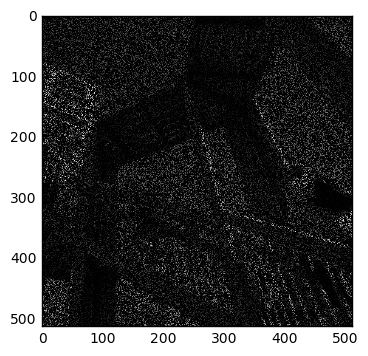

In [47]:
plt.imshow(Z[1]+Z[0]+Noisyascent)
plt.show()

## Working with videos

It appears that working with videos is a bit tidious, thus installing some packages might be first necessary.
- ffmpeg https://ffmpeg.org/
- skvideo http://www.scikit-video.org/stable/

In the end, it didn't work out. We decided to work with *OpenCV*. The easiest way to install it when using Conda:
> conda install -c https://conda.binstar.org/menpo opencv

But it didn't work out either.

we ended up trying:
- movie py https://github.com/Zulko/moviepy/ which seems user friendly but not highly optimized for what we do

Note: http://simplecv.org/ might be relevant too

In [48]:
#Sample Video http://www.engr.colostate.edu/me/facil/dynamics/avis.htm

In [49]:
#http://www.math.nus.edu.sg/~matzuows/vedio_denoising.pdf
# import cv2
import os
file =  os.path.join("C:/Users/H/Documents/Japet/Cours/ML/Projet/","flame.avi")
print(file)

C:/Users/H/Documents/Japet/Cours/ML/Projet/flame.avi


In [50]:
import moviepy
import pygame
from moviepy.editor import *

video = VideoFileClip(file).subclip(0,10)

In [51]:
video.show()

In [52]:
import SimpleCV

In [53]:
from SimpleCV import Camera

cam = Camera()

while True:
    img = cam.getImage()
    img.show()

IOError: [Errno 2] No such file or directory: 'C:\\Program Files\\Anaconda2\\lib\\site-packages\\SimpleCV\\sampleimages\\simplecv.png'